In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install ripser

In [ ]:
import sys
import os

# Add /content to path
sys.path.insert(0, '/content/drive/MyDrive/SF2956')
import stablerank.srank as sr
import geometry_objects_2021 as ge


from ripser import ripser

import _pickle as pickle

import numpy as np
inf=float("inf")

import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import scipy.spatial as spatial

from scipy.spatial.distance import cdist, pdist, squareform

import scipy.stats as st


from timeit import default_timer as timer
from datetime import timedelta

from sklearn import svm
from sklearn.metrics import accuracy_score


from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


# My project


In [ ]:
import sys
import os
# Add /content to path
sys.path.insert(0, '/content/drive/MyDrive/SF2956/')
import stablerank.srank as sr
from stablerank.srank import BC
import geometry_objects_2021 as ge


from ripser import ripser

import _pickle as pickle

import numpy as np
inf=float("inf")

import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import scipy.spatial as spatial

from scipy.spatial.distance import cdist, pdist, squareform

import scipy.stats as st


from timeit import default_timer as timer
from datetime import timedelta

from sklearn import svm
from sklearn.metrics import accuracy_score

from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import svm
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import pdist, squareform
from collections import Counter
import ipywidgets as widgets

In [ ]:
# Load the data and split the training set

df = pd.read_csv('/content/drive/MyDrive/SF2956/IMU-based_Human_Activity_Recignition_Dataset.csv')
print(df.head())
X = df.drop('activity', axis=1).values  # shape: (N, D)
y = df['activity'].values
le = LabelEncoder()
y_encoded = le.fit_transform(y)

idx = np.arange(len(X))
train_idx, test_idx = train_test_split(idx, test_size=0.2, random_state=42, shuffle=True)
train_idx.sort()
test_idx.sort()
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

clf = SVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the SVM model: {accuracy}")


     ax     ay    az    gx    gy    gz  activity
0 -1248  14736 -6780  1057  1422  2038         1
1 -1116  14136 -6800  2237  1415  3538         1
2 -1368  14320 -7160  2618  1289  3947         1
3 -1492  14484 -7600  2560  1260  3595         1
4 -1088  14440 -7636  2395  1714  3129         1
(12784, 6) (3196, 6) (12784,) (3196,)
Accuracy of the SVM model: 0.817584480600751


In [ ]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

models = {
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(n_neighbors=10),
    "RandomForest": RandomForestClassifier(n_estimators=10, random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "MLP": MLPClassifier(hidden_layer_sizes=(256,128), max_iter=100, random_state=42)
}

for name, clf in models.items():
    clf.fit(X_train, y_train)
    acc = accuracy_score(y_test, clf.predict(X_test))
    print(f"{name} Accuracy: {acc:.4f}")


SVM Accuracy: 0.8176
KNN Accuracy: 0.8598
RandomForest Accuracy: 0.8461
LogisticRegression Accuracy: 0.3170
MLP Accuracy: 0.8561


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


## visualization



Given the triaxial accelerometer signals
$\mathbf{a}(t) = [a_x(t), a_y(t), a_z(t)]$,
we can approximate the subject's motion trajectory by applying
a simple numerical double integration.
Assuming a constant sampling interval $\Delta t$,
the velocity and position are estimated as:
$$
\mathbf{v}(t_k) = \sum_{i=1}^{k} \mathbf{a}(t_i) \, \Delta t,
\qquad
\mathbf{p}(t_k) = \sum_{i=1}^{k} \mathbf{v}(t_i) \, \Delta t,
$$
where $\mathbf{v}(t_k)$ and $\mathbf{p}(t_k)$ denote the velocity and position
at time step $t_k$, respectively.
Before integration, the acceleration signals are mean-centered to remove
static bias (e.g., due to sensor drift or gravity offset).

Although this method does not produce metrically accurate positions
(due to integration drift and uncorrected gravity components),
it provides an \emph{approximate spatial trajectory} that reveals
the dynamic patterns of different activities.


By visualizing both the 3D trajectory $\mathbf{p}(t)$ and the
accelerometer time series $\mathbf{a}(t)$ for each activity,
we can observe that different activities produce
distinct motion signatures.
For instance, walking or running activities tend to exhibit
periodic oscillatory trajectories,
while static activities such as standing or sitting
produce compact, nearly stationary patterns.
Similarly, the accelerometer waveforms show characteristic
amplitude and frequency variations that correspond to
the intensity and rhythm of motion.

In [ ]:
activity_labels = sorted(df['activity'].unique())

@interact(
    activity=widgets.Dropdown(
        options=activity_labels,
        value=activity_labels[0],
        description='Activity:'
    ),
    window=widgets.IntSlider(
        value=1000, min=200, max=3000, step=100,
        description='Window size:'
    )
)
def plot_activity_trajectory(activity, window):
    """
    Interactively display the 3D trajectory and accelerometer time-series
    for a selected activity segment.
    """

    segment = df[df['activity'] == activity].copy().reset_index(drop=True)

    if len(segment) < window:
        print(f" Activity {activity} has only {len(segment)} samples (< window). Showing all.")
        window = len(segment)

    # Use only the first 'window' samples
    segment = segment.iloc[:window]

    acc = segment[['ax', 'ay', 'az']].to_numpy().astype(float)
    acc = acc - np.mean(acc, axis=0)

    # Simple double integration to obtain approximate position trajectory
    dt = 0.02  # Sampling interval
    vel = np.cumsum(acc * dt, axis=0)
    pos = np.cumsum(vel * dt, axis=0)

    fig = plt.figure(figsize=(12, 6))

    # 3D trajectory plot
    ax = fig.add_subplot(121, projection='3d')
    ax.plot(pos[:, 0], pos[:, 1], pos[:, 2], color='royalblue')
    ax.set_title(f'3D Trajectory of Activity {activity}')
    ax.set_xlabel('X position')
    ax.set_ylabel('Y position')
    ax.set_zlabel('Z position')
    ax.grid(True, alpha=0.3)

    # Time-series waveform plot
    t = np.arange(len(segment)) * dt
    ax2 = fig.add_subplot(122)
    ax2.plot(t, segment['ax'], label='ax', alpha=0.7)
    ax2.plot(t, segment['ay'], label='ay', alpha=0.7)
    ax2.plot(t, segment['az'], label='az', alpha=0.7)
    ax2.set_title(f'Accelerometer Signals (Activity {activity})')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Acceleration')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


interactive(children=(Dropdown(description='Activity:', options=(np.int64(1), np.int64(2), np.int64(3), np.int…

## sliding window

In [ ]:

def sliding_point_clouds(X, y, window_size=200, step=50, min_points=2):
    """
    Slice a time series X (shape: (T, d)) into multiple sliding-window point clouds.
    Parameters:
      window_size : Number of time steps in each sliding window
        step : Step size between consecutive windows
    Returns:
      clouds: list of arrays, each array shape (window_size, d)
      labels: numpy array of labels (one label per kept window)
    """
    T, d = X.shape
    clouds = []
    labels = []
    for start in range(0, T - window_size + 1, step):
        w = X[start:start + window_size, :]   # shape (window_size, d)
        if w.shape[0] < min_points:
            continue

        if y is not None:
            wl = list(y[start:start + window_size])
            # keep only windows with consistent labels
            if len(set(wl)) == 1:
                clouds.append(w.copy())
                labels.append(wl[0])
            else:
                # Mixed labels in window → discard
                continue
        else:
            clouds.append(w.copy())

    return clouds, np.array(labels)

def flatten_point_clouds(clouds):
    """
    Each point cloud with shape (window_size, d) is flattened into a
    1D vector of length (window_size * d).
    """
    flattened = []
    for cloud in clouds:
        flattened.append(cloud.flatten())
    return np.array(flattened)


In [ ]:
window_size = 100
step = 10

train_clouds, y_train_slide = sliding_point_clouds(X_train, y_train, window_size=window_size, step=step)
test_clouds, y_test_slide = sliding_point_clouds(X_test, y_test, window_size=window_size, step=step)

print(f"Generated {len(train_clouds)} train windows, {len(test_clouds)} test windows")
print(f"Each window shape: {train_clouds[0].shape}")

Generated 1219 train windows, 260 test windows
Each window shape: (100, 6)


### visualization after sliding window

In [ ]:
# Define available distance metrics
distance_metrics = ['euclidean', 'cityblock', 'cosine', 'chebyshev']

@widgets.interact(
    metric=widgets.Dropdown(options=distance_metrics, value='euclidean', description='Distance Metric:'),
    sample=widgets.IntSlider(value=5, min=0, max=len(train_clouds[0])-1, description='Sample:')
)
def plot_distance_distribution(metric, sample):
    """
    Interactive function to visualize the distance distribution
    of a selected sample to all other samples in the dataset.
    """

    # Compute full pairwise distance matrix
    distances = squareform(pdist(train_clouds[0], metric))

    plt.figure(figsize=(10, 6))

    # Plot histogram for the selected sample
    plt.hist(distances[sample], bins=30, alpha=0.75, label=f'Sample {sample}')

    plt.title(f'{metric.capitalize()} Distance Distribution (Sample {sample})')
    plt.xlabel('Distance')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Print basic statistics
    dist_values = distances[sample]
    print(f"Distance Metric: {metric}")
    print(f"Sample {sample}: min={dist_values.min():.3f}, max={dist_values.max():.3f}, "
          f"mean={dist_values.mean():.3f}, std={dist_values.std():.3f}")


interactive(children=(Dropdown(description='Distance Metric:', options=('euclidean', 'cityblock', 'cosine', 'c…

Euclidean : min=0.000, max=6.096, mean=2.041, std=1.081
Cityblock : min=0.000, max=10.211, mean=3.983, std=1.803
Cosine    : min=0.000, max=1.554, mean=0.699, std=0.496
Chebyshev : min=0.000, max=5.414, mean=1.538, std=1.030


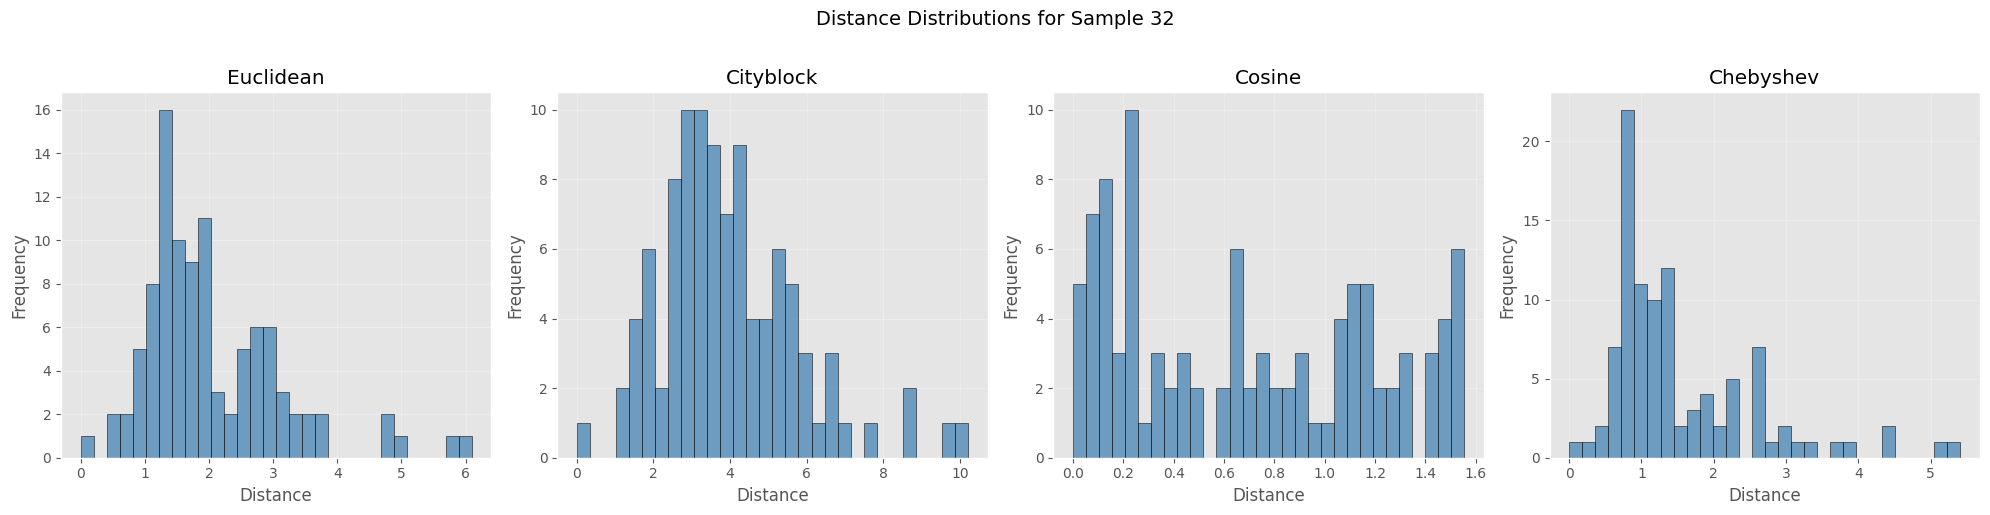

In [ ]:
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

# Define available distance metrics
distance_metrics = ['euclidean', 'cityblock', 'cosine', 'chebyshev']

# Choose the sample index to visualize
sample = 32

# Create figure with 1 row and 4 columns
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle(f"Distance Distributions for Sample {sample}", fontsize=14, y=1.02)

# Loop through each distance metric
for i, metric in enumerate(distance_metrics):
    # Compute pairwise distance matrix
    distances = squareform(pdist(train_clouds[0], metric))

    # Select the sample's distance values
    dist_values = distances[sample]

    # Plot histogram
    axes[i].hist(dist_values, bins=30, alpha=0.75, color='steelblue', edgecolor='black')
    axes[i].set_title(f"{metric.capitalize()}")
    axes[i].set_xlabel("Distance")
    axes[i].set_ylabel("Frequency")
    axes[i].grid(True, alpha=0.3)

    # Print basic statistics
    print(f"{metric.capitalize():<10}: min={dist_values.min():.3f}, "
          f"max={dist_values.max():.3f}, mean={dist_values.mean():.3f}, "
          f"std={dist_values.std():.3f}")

plt.tight_layout()
plt.show()


/tmp/ipython-input-1510374023.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_labels))


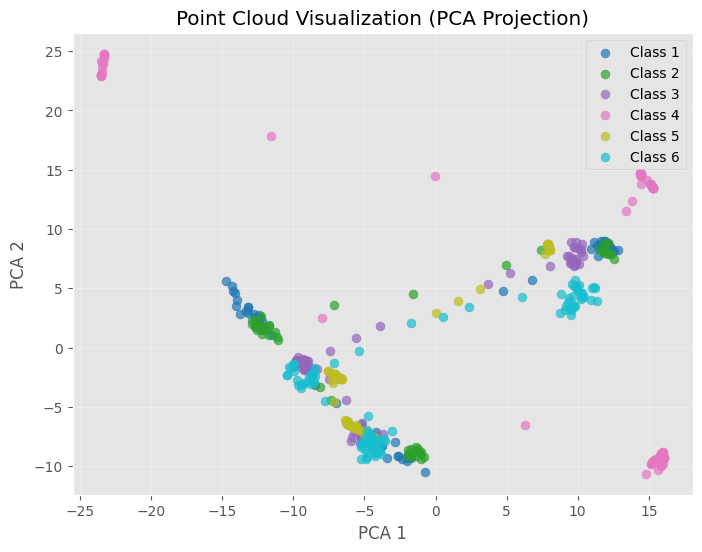

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def visualize_point_clouds(clouds, labels, n_samples=300, dim=3):
    """
    Visualize sliding window point clouds using PCA for dimensionality reduction.

    Parameters:
        clouds : list of np.ndarray
            List of point clouds (each of shape (window_size, d))
        labels : np.ndarray
            One label per window
        n_samples : int
            Number of windows to visualize (random subset)
        dim : int
            Target dimension for visualization (2 or 3)
    """
    # Convert clouds to flat matrix for PCA
    X_flat = np.array([c.flatten() for c in clouds])

    # Randomly sample for visualization (if too many)
    if len(X_flat) > n_samples:
        idx = np.random.choice(len(X_flat), n_samples, replace=False)
        X_flat = X_flat[idx]
        labels = labels[idx]

    # Reduce dimension for visualization
    pca = PCA(n_components=dim)
    X_vis = pca.fit_transform(X_flat)

    # Choose color map
    unique_labels = np.unique(labels)
    colors = plt.cm.get_cmap("tab10", len(unique_labels))

    # Plot
    plt.figure(figsize=(8, 6))
    if dim == 2:
        for i, lab in enumerate(unique_labels):
            plt.scatter(
                X_vis[labels == lab, 0], X_vis[labels == lab, 1],
                color=colors(i), label=f"Class {lab+1}", alpha=0.7, s=40
            )
        plt.xlabel("PCA 1")
        plt.ylabel("PCA 2")
    elif dim == 3:
        from mpl_toolkits.mplot3d import Axes3D
        ax = plt.figure(figsize=(9, 7)).add_subplot(111, projection='3d')
        for i, lab in enumerate(unique_labels):
            ax.scatter(
                X_vis[labels == lab, 0], X_vis[labels == lab, 1], X_vis[labels == lab, 2],
                color=colors(i), label=f"Class {lab+1}", alpha=0.7, s=40
            )
        ax.set_xlabel("PCA 1")
        ax.set_ylabel("PCA 2")
        ax.set_zlabel("PCA 3")

    plt.title("Point Cloud Visualization (PCA Projection)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

visualize_point_clouds(train_clouds, y_train_slide, n_samples=500, dim=2)

In [ ]:
# Flatten the sliding window point clouds into 2D feature matrices
X_train_flat = flatten_point_clouds(train_clouds)
X_test_flat = flatten_point_clouds(test_clouds)

print(f"Flattened feature shape - Train: {X_train_flat.shape}, Test: {X_test_flat.shape}")

# # Train SVM
# clf = SVC()
# clf.fit(X_train_flat, y_train_slide)

# y_pred = clf.predict(X_test_flat)
# accuracy = accuracy_score(y_test_slide, y_pred)

# print(f"Accuracy of the SVM model: {accuracy:.4f}")

# print("\nClass distribution:")
# print(f"Train: {Counter(y_train_slide)}")
# print(f"Test: {Counter(y_test_slide)}")


Flattened feature shape - Train: (1219, 600), Test: (260, 600)


In [ ]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

models = {
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(n_neighbors=20),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "MLP": MLPClassifier(hidden_layer_sizes=(256,128), max_iter=500, random_state=42)
}

for name, clf in models.items():
    clf.fit(X_train_flat, y_train_slide)
    acc = accuracy_score(y_test_slide, clf.predict(X_test_flat))
    print(f"{name} Accuracy: {acc:.4f}")


SVM Accuracy: 0.9231
KNN Accuracy: 0.3885
RandomForest Accuracy: 0.8462
LogisticRegression Accuracy: 0.4500
MLP Accuracy: 0.7538


## calculate the stable rank (h0,h1)

### multiple linkage

In [ ]:
# Define distance metrics and clustering methods
distance_metrics = ['euclidean', 'cityblock', 'cosine', 'chebyshev']
clustering_methods = ['single', 'complete', 'average', 'ward']

train_h0sr = {}
test_h0sr = {}
train_h1sr = {}
test_h1sr = {}

# Loop over distance metrics
for metric in distance_metrics:
    print(f"\n=== Distance metric: {metric} ===")

    # Step 1: Compute distance matrices for each window (point cloud)
    # train_dist = [sr.Distance(squareform(pdist(fig, metric))) for fig in train_clouds]
    # test_dist  = [sr.Distance(squareform(pdist(fig, metric))) for fig in test_clouds]
    train_dist = [sr.Distance(squareform(pdist(fig + 1e-10 * np.random.randn(*fig.shape), metric))) for fig in train_clouds]
    test_dist  = [sr.Distance(squareform(pdist(fig + 1e-10 * np.random.randn(*fig.shape), metric))) for fig in test_clouds]


    # Initialize dictionaries for current distance metric
    train_h0sr[metric] = {}
    test_h0sr[metric] = {}

    # Step 2: Compute H0 stable rank for each clustering method
    for cm in clustering_methods:
        print(f"\n--- Clustering method: {cm} ---")

        test_h0sr[metric][cm] = [d.get_h0sr(clustering_method=cm) for d in test_dist]
        train_h0sr[metric][cm] = [d.get_h0sr(clustering_method=cm) for d in train_dist]

        # Keep indices where computation succeeded
        train_keep_idx = [i for i, pc in enumerate(train_h0sr[metric][cm])]
        test_keep_idx  = [i for i, pc in enumerate(test_h0sr[metric][cm])]

        # Filter results and corresponding labels
        train_h0sr[metric][cm] = [train_h0sr[metric][cm][i] for i in train_keep_idx]
        test_h0sr[metric][cm]  = [test_h0sr[metric][cm][i] for i in test_keep_idx]

        y_train_h0 = np.array([y_train_slide[i] for i in train_keep_idx])
        y_test_h0  = np.array([y_test_slide[i] for i in test_keep_idx])

    # Step 3: Compute barcodes (shared for all clustering methods)
    train_bc = [d.get_bc(maxdim=1) for d in train_dist]
    test_bc  = [d.get_bc(maxdim=1) for d in test_dist]

    print(f"Compute H1 stable rank for distance metric: {metric}")

    # Step 4: Compute H1 stable rank (only once per distance metric)
    train_h1sr[metric] = [sr.bc_to_sr(bi, degree="H1") for bi in train_bc]
    test_h1sr[metric]  = [sr.bc_to_sr(bi, degree="H1") for bi in test_bc]

    # train_h1sr[metric] = [
    #     {"index": i, "sr": sr.bc_to_sr(bi, degree="H1")}
    #     for i, bi in enumerate(train_bc)
    # ]
    # test_h1sr[metric] = [
    #     {"index": i, "sr": sr.bc_to_sr(bi, degree="H1")}
    #     for i, bi in enumerate(test_bc)
    # ]

    # Use indices from the last clustering method (they are equivalent)
    # train_h1sr[metric] = [train_h1sr[metric][i] for i in train_keep_idx]
    # test_h1sr[metric]  = [test_h1sr[metric][i] for i in test_keep_idx]



=== Distance metric: euclidean ===

--- Clustering method: single ---

--- Clustering method: complete ---

--- Clustering method: average ---

--- Clustering method: ward ---
Compute H1 stable rank for distance metric: euclidean

=== Distance metric: cityblock ===

--- Clustering method: single ---

--- Clustering method: complete ---

--- Clustering method: average ---

--- Clustering method: ward ---
Compute H1 stable rank for distance metric: cityblock

=== Distance metric: cosine ===

--- Clustering method: single ---

--- Clustering method: complete ---

--- Clustering method: average ---

--- Clustering method: ward ---
Compute H1 stable rank for distance metric: cosine

=== Distance metric: chebyshev ===

--- Clustering method: single ---

--- Clustering method: complete ---

--- Clustering method: average ---

--- Clustering method: ward ---
Compute H1 stable rank for distance metric: chebyshev


### Vietoris-Rips

In [ ]:
from ripser import ripser
from persim import plot_diagrams

distance_metrics = ['euclidean', 'cityblock', 'cosine', 'correlation']

train_h0sr = {}
test_h0sr = {}
train_h1sr = {}
test_h1sr = {}

for metric in distance_metrics:
    print(f"\n=== Distance metric: {metric} ===")

    # Step 1: Compute distance matrices for each window (point cloud)
    train_dists = [squareform(pdist(fig, metric)) for fig in train_clouds]
    test_dists  = [squareform(pdist(fig, metric)) for fig in test_clouds]
    # train_dist = [sr.Distance(squareform(pdist(fig + 1e-10 * np.random.randn(*fig.shape), metric))) for fig in train_clouds]
    # test_dist  = [sr.Distance(squareform(pdist(fig + 1e-10 * np.random.randn(*fig.shape), metric))) for fig in test_clouds]


    # Step 2: Compute Vietoris–Rips persistent homology
    train_barcodes = [ripser(d, distance_matrix=True, maxdim=1)['dgms'] for d in train_dists]
    test_barcodes  = [ripser(d, distance_matrix=True, maxdim=1)['dgms'] for d in test_dists]

    # Step 3: Extract H0/H1 stable ranks or persistence functions
    # train_h0sr[metric] = [sr.bc_to_sr({"H0": bc[0]}, degree="H0") for bc in train_barcodes]
    # train_h1sr[metric] = [sr.bc_to_sr({"H1": bc[1]}, degree="H1") for bc in train_barcodes]

    # test_h0sr[metric] = [sr.bc_to_sr({"H0": bc[0]}, degree="H0") for bc in test_barcodes]
    # test_h1sr[metric] = [sr.bc_to_sr({"H1": bc[1]}, degree="H1") for bc in test_barcodes]
    train_h0sr[metric] = [
        sr.bc_to_sr({"H0": BC(bc[0])}, degree="H0")
        for bc in train_barcodes
    ]

    train_h1sr[metric] = [
        sr.bc_to_sr({"H1": BC(bc[1])}, degree="H1")
        for bc in train_barcodes
    ]

    test_h0sr[metric] = [
        sr.bc_to_sr({"H0": BC(bc[0])}, degree="H0")
        for bc in test_barcodes
    ]

    test_h1sr[metric] = [
        sr.bc_to_sr({"H1": BC(bc[1])}, degree="H1")
        for bc in test_barcodes
    ]

    train_keep_idx = [i for i, pc in enumerate(train_h0sr[metric])]
    test_keep_idx  = [i for i, pc in enumerate(test_h0sr[metric])]

    # Filter results and corresponding labels
    train_h0sr[metric] = [train_h0sr[metric][i] for i in train_keep_idx]
    test_h0sr[metric]  = [test_h0sr[metric][i] for i in test_keep_idx]

    y_train_h0 = np.array([y_train_slide[i] for i in train_keep_idx])
    y_test_h0  = np.array([y_test_slide[i] for i in test_keep_idx])

    print(f"Computed Vietoris–Rips persistent homology for {metric}")




=== Distance metric: euclidean ===
Computed Vietoris–Rips persistent homology for euclidean

=== Distance metric: cityblock ===
Computed Vietoris–Rips persistent homology for cityblock

=== Distance metric: cosine ===
Computed Vietoris–Rips persistent homology for cosine

=== Distance metric: correlation ===
Computed Vietoris–Rips persistent homology for correlation


## Build kernel matrices

### multiple linkage

In [ ]:

h0_kernel_train = {}
h0_kernel_test = {}

# Loop through all distance metrics
for metric in distance_metrics:
    print(f"\n=== Distance Metric: {metric} ===")

    h0_kernel_train[metric] = {}
    h0_kernel_test[metric] = {}

    # Loop through all clustering methods
    for cm in clustering_methods:
        print(f"Clustering Method: {cm}")

        # === Extract and flatten stable rank data ===
        shapes = [pc.content.shape for pc in train_h0sr[metric][cm]]
        shape_counts = {s: shapes.count(s) for s in set(shapes)}
        main_shape = max(shape_counts, key=shape_counts.get)  # most common shape
        # print(f"Main shape: {main_shape}, keeping {shape_counts[main_shape]}/{len(shapes)} samples")

        # ---  Filter consistent samples only ---
        train_valid = [pc for pc in train_h0sr[metric][cm] if pc.content.shape == main_shape]
        test_valid  = [pc for pc in test_h0sr[metric][cm]  if pc.content.shape == main_shape]

        # Each 'pc' is a stable rank object; we flatten its content to a 1D vector
        train_matrix = np.stack([pc.content.flatten() for pc in train_valid])
        test_matrix  = np.stack([pc.content.flatten() for pc in test_valid])

        # ===  Normalize (z-score normalization for stability) ===
        train_matrix = (train_matrix - train_matrix.mean(axis=0)) / (train_matrix.std(axis=0) + 1e-6)
        test_matrix  = (test_matrix - test_matrix.mean(axis=0)) / (test_matrix.std(axis=0) + 1e-6)

        # === Compute kernel matrices via matrix multiplication ===
        # Kernel_train: similarity between training samples
        # Kernel_test: similarity between test and training samples
        h0_kernel_train[metric][cm] = train_matrix @ train_matrix.T
        h0_kernel_test[metric][cm] = test_matrix @ train_matrix.T

print("\n H0 kernel matrices have been successfully computed for all metrics and clustering methods.")



=== Distance Metric: euclidean ===
Clustering Method: single
Clustering Method: complete
Clustering Method: average
Clustering Method: ward

=== Distance Metric: cityblock ===
Clustering Method: single
Clustering Method: complete
Clustering Method: average
Clustering Method: ward

=== Distance Metric: cosine ===
Clustering Method: single
Clustering Method: complete
Clustering Method: average
Clustering Method: ward

=== Distance Metric: chebyshev ===
Clustering Method: single
Clustering Method: complete
Clustering Method: average
Clustering Method: ward

 H0 kernel matrices have been successfully computed for all metrics and clustering methods.


In [ ]:
# === Step 5'. Build H1 kernel matrices (no clustering methods) ===

h1_kernel_train = {}
h1_kernel_test = {}

# Loop through all distance metrics
for metric in distance_metrics:
    print(f"\n=== Distance Metric (H1): {metric} ===")

    # === Step 5.1 Extract and flatten stable rank data ===
    shapes = [pc.content.shape for pc in train_h1sr[metric]]
    shape_counts = {s: shapes.count(s) for s in set(shapes)}
    main_shape = max(shape_counts, key=shape_counts.get)  # most common shape
    print(f"Main shape: {main_shape}, keeping {shape_counts[main_shape]}/{len(shapes)} samples")

    # --- 2. Filter consistent samples only ---
    train_valid = [pc for pc in train_h1sr[metric] if pc.content.shape == main_shape]
    test_valid  = [pc for pc in test_h1sr[metric]  if pc.content.shape == main_shape]

    # Each 'pc' is a stable rank object; we flatten its content to a 1D vector
    train_matrix = np.stack([pc.content.flatten() for pc in train_valid])
    test_matrix  = np.stack([pc.content.flatten() for pc in test_valid])

    # === Step 5.2 Normalize (z-score normalization for stability) ===
    train_matrix = (train_matrix - train_matrix.mean(axis=0)) / (train_matrix.std(axis=0) + 1e-6)
    test_matrix  = (test_matrix - test_matrix.mean(axis=0)) / (test_matrix.std(axis=0) + 1e-6)

    # === Step 5.3 Compute kernel matrices via matrix multiplication ===
    # Kernel_train: similarity between training samples
    # Kernel_test: similarity between test and training samples
    h1_kernel_train[metric] = train_matrix @ train_matrix.T
    h1_kernel_test[metric]  = test_matrix @ train_matrix.T

print("\n H1 kernel matrices have been successfully computed for all distance metrics.")



=== Distance Metric (H1): euclidean ===
Main shape: (2, 31), keeping 82/1219 samples

=== Distance Metric (H1): cityblock ===
Main shape: (2, 40), keeping 58/1219 samples

=== Distance Metric (H1): chebyshev ===
Main shape: (2, 56), keeping 53/1219 samples

 H1 kernel matrices have been successfully computed for all distance metrics.


### VR

In [ ]:
# ===  Build kernel matrices (matrix multiplication acceleration) ===

h0_kernel_train = {}
h0_kernel_test = {}

# Loop through all distance metrics
for metric in distance_metrics:
    print(f"\n=== Distance Metric: {metric} ===")

    h0_kernel_train[metric] = {}
    h0_kernel_test[metric] = {}

    # === Step 5.1 Extract and flatten stable rank data ===
    shapes = [pc.content.shape for pc in train_h0sr[metric]]
    shape_counts = {s: shapes.count(s) for s in set(shapes)}
    main_shape = max(shape_counts, key=shape_counts.get)  # most common shape
    print(f"H0: Main shape: {main_shape}, keeping {shape_counts[main_shape]}/{len(shapes)} samples")


    # --- 2. Filter consistent samples only ---
    train_valid = [pc for pc in train_h0sr[metric] if pc.content.shape == main_shape]
    test_valid  = [pc for pc in test_h0sr[metric]  if pc.content.shape == main_shape]

    # Each 'pc' is a stable rank object; we flatten its content to a 1D vector
    train_matrix = np.stack([pc.content.flatten() for pc in train_valid])
    test_matrix  = np.stack([pc.content.flatten() for pc in test_valid])

    # === Step 5.2 Normalize (z-score normalization for stability) ===
    train_matrix = (train_matrix - train_matrix.mean(axis=0)) / (train_matrix.std(axis=0) + 1e-6)
    test_matrix  = (test_matrix - test_matrix.mean(axis=0)) / (test_matrix.std(axis=0) + 1e-6)

    # === Step 5.3 Compute kernel matrices via matrix multiplication ===
    # Kernel_train: similarity between training samples
    # Kernel_test: similarity between test and training samples
    h0_kernel_train[metric] = train_matrix @ train_matrix.T
    h0_kernel_test[metric] = test_matrix @ train_matrix.T

print("\n H0 kernel matrices have been successfully computed for all metrics and clustering methods.")



=== Distance Metric: euclidean ===
H0: Main shape: (2, 100), keeping 1219/1219 samples

=== Distance Metric: cityblock ===
H0: Main shape: (2, 100), keeping 1219/1219 samples

=== Distance Metric: cosine ===
H0: Main shape: (2, 100), keeping 1219/1219 samples

=== Distance Metric: correlation ===
H0: Main shape: (2, 100), keeping 1219/1219 samples

 H0 kernel matrices have been successfully computed for all metrics and clustering methods.


In [ ]:
# === Step 5'. Build H1 kernel matrices (no clustering methods) ===

h1_kernel_train = {}
h1_kernel_test = {}

# Loop through all distance metrics
for metric in distance_metrics:
    print(f"\n=== Distance Metric (H1): {metric} ===")

    # === Step 5.1 Extract and flatten stable rank data ===
    shapes = [pc.content.shape for pc in train_h1sr[metric]]
    shape_counts = {s: shapes.count(s) for s in set(shapes)}
    main_shape = max(shape_counts, key=shape_counts.get)  # most common shape
    print(f"Main shape: {main_shape}, keeping {shape_counts[main_shape]}/{len(shapes)} samples")

    # --- 2. Filter consistent samples only ---
    train_valid = [pc for pc in train_h1sr[metric] if pc.content.shape == main_shape]
    test_valid  = [pc for pc in test_h1sr[metric]  if pc.content.shape == main_shape]

    # Each 'pc' is a stable rank object; we flatten its content to a 1D vector
    train_matrix = np.stack([pc.content.flatten() for pc in train_valid])
    test_matrix  = np.stack([pc.content.flatten() for pc in test_valid])

    # === Step 5.2 Normalize (z-score normalization for stability) ===
    train_matrix = (train_matrix - train_matrix.mean(axis=0)) / (train_matrix.std(axis=0) + 1e-6)
    test_matrix  = (test_matrix - test_matrix.mean(axis=0)) / (test_matrix.std(axis=0) + 1e-6)

    # === Step 5.3 Compute kernel matrices via matrix multiplication ===
    # Kernel_train: similarity between training samples
    # Kernel_test: similarity between test and training samples
    h1_kernel_train[metric] = train_matrix @ train_matrix.T
    h1_kernel_test[metric]  = test_matrix @ train_matrix.T

print("\n H1 kernel matrices have been successfully computed for all distance metrics.")



=== Distance Metric (H1): euclidean ===
Main shape: (2, 31), keeping 82/1219 samples

=== Distance Metric (H1): cityblock ===
Main shape: (2, 40), keeping 58/1219 samples

=== Distance Metric (H1): cosine ===
Main shape: (2, 37), keeping 70/1219 samples

=== Distance Metric (H1): correlation ===
Main shape: (2, 32), keeping 84/1219 samples

 H1 kernel matrices have been successfully computed for all distance metrics.


In [ ]:
import numpy as np

# === Step 5'. Build H₁ kernel matrices with interpolation & label sync ===

h1_kernel_train = {}
h1_kernel_test = {}

target_length = 500  # interpolation target length

for metric in distance_metrics:
    print(f"\n=== Distance Metric (H1): {metric} ===")

    train_contents = [pc.content for pc in train_h1sr[metric]]
    test_contents  = [pc.content for pc in test_h1sr[metric]]

    # === Define interpolation helper ===
    def interpolate_sr(content, target_len=target_length):
        """Linearly interpolate 2×N stable rank to target_len points."""
        try:
            x = np.linspace(0, 1, content.shape[1])
            x_new = np.linspace(0, 1, target_len)
            y = content[1, :] if content.shape[0] == 2 else content.flatten()
            y_new = np.interp(x_new, x, y)
            return y_new
        except Exception:
            return None

    # === Apply interpolation & keep only valid samples ===
    train_interp, valid_train_idx = [], []
    for i, pc in enumerate(train_contents):
        y_new = interpolate_sr(pc)
        if y_new is not None:
            train_interp.append(y_new)
            valid_train_idx.append(i)

    test_interp, valid_test_idx = [], []
    for i, pc in enumerate(test_contents):
        y_new = interpolate_sr(pc)
        if y_new is not None:
            test_interp.append(y_new)
            valid_test_idx.append(i)

    # Convert to arrays
    train_matrix = np.stack(train_interp)
    test_matrix  = np.stack(test_interp)

    # === Sync labels ===
    y_train_h1_aligned = np.array(y_train_h0)[valid_train_idx]
    y_test_h1_aligned  = np.array(y_test_h0)[valid_test_idx]

    print(f"Kept {len(train_matrix)}/{len(train_h1sr[metric])} train, "
          f"{len(test_matrix)}/{len(test_h1sr[metric])} test samples after interpolation.")

    # === Normalize ===
    train_matrix = (train_matrix - train_matrix.mean(axis=0)) / (train_matrix.std(axis=0) + 1e-6)
    test_matrix  = (test_matrix - test_matrix.mean(axis=0)) / (test_matrix.std(axis=0) + 1e-6)

    # === Compute kernels ===
    h1_kernel_train[metric] = train_matrix @ train_matrix.T
    h1_kernel_test[metric]  = test_matrix @ train_matrix.T

    h1_kernel_train[metric + "_labels"] = y_train_h1_aligned
    h1_kernel_test[metric + "_labels"]  = y_test_h1_aligned

print("\n H₁ kernel matrices successfully computed and labels aligned.")



=== Distance Metric (H1): euclidean ===
Kept 1219/1219 train, 260/260 test samples after interpolation.

=== Distance Metric (H1): cityblock ===
Kept 1219/1219 train, 260/260 test samples after interpolation.

=== Distance Metric (H1): cosine ===
Kept 1219/1219 train, 260/260 test samples after interpolation.

=== Distance Metric (H1): correlation ===
Kept 1219/1219 train, 260/260 test samples after interpolation.

✅ H₁ kernel matrices successfully computed and labels aligned.


## SVM

### multiple linkage

In [ ]:
from sklearn import svm
from sklearn.metrics import accuracy_score
import pandas as pd

# === Step 6. Train SVM classifier and evaluate performance ===
svm_results = []

print("\n=== Step 6: Training SVM and evaluating ===")

for metric in distance_metrics:
    print(f"\n=== Distance Metric: {metric} ===")

    for cm in clustering_methods:
        print(f"Clustering Method: {cm}")

        # Skip if this metric/cm combination failed earlier (some missing shapes)
        if cm not in h0_kernel_train[metric] or cm not in h0_kernel_test[metric]:
            print(f" Skipping {metric}-{cm} due to missing kernel data.")
            continue

        K_train = h0_kernel_train[metric][cm]
        K_test = h0_kernel_test[metric][cm]

        # Check dimensions for safety
        if K_train.shape[0] != len(y_train_h0) or K_test.shape[0] != len(y_test_h0):
            print(f" Shape mismatch: kernel {K_train.shape}, labels train={len(y_train_h0)}, test={len(y_test_h0)}")
            continue

        # Initialize SVM with precomputed kernel
        # clf = svm.SVC(kernel='precomputed')
        # clf = RandomForestClassifier(n_estimators=10, random_state=42)
        clf = KNeighborsClassifier(n_neighbors=10)

        # Fit on training kernel and labels
        clf.fit(K_train, y_train_h0)

        # Predict on test kernel
        y_pred = clf.predict(K_test)

        # Compute accuracy
        acc = accuracy_score(y_test_h0, y_pred)

        print(f" {metric}-{cm}: Accuracy = {acc:.4f}")

        # Save result for summary table
        svm_results.append({
            'Distance Metric': metric,
            'Clustering Method': cm,
            'Accuracy': acc
        })

# Convert results to DataFrame for easy visualization
results_df = pd.DataFrame(svm_results)
print("\n=== SVM Evaluation Summary ===")
print(results_df.sort_values(by='Accuracy', ascending=False))



=== Step 6: Training SVM and evaluating ===

=== Distance Metric: euclidean ===
Clustering Method: single
 euclidean-single: Accuracy = 0.7885
Clustering Method: complete
 euclidean-complete: Accuracy = 0.8308
Clustering Method: average
 euclidean-average: Accuracy = 0.8269
Clustering Method: ward
 euclidean-ward: Accuracy = 0.8308

=== Distance Metric: cityblock ===
Clustering Method: single
 cityblock-single: Accuracy = 0.7769
Clustering Method: complete
 cityblock-complete: Accuracy = 0.8154
Clustering Method: average
 cityblock-average: Accuracy = 0.8115
Clustering Method: ward
 cityblock-ward: Accuracy = 0.8423

=== Distance Metric: cosine ===
Clustering Method: single
 cosine-single: Accuracy = 0.5769
Clustering Method: complete
 cosine-complete: Accuracy = 0.6231
Clustering Method: average
 cosine-average: Accuracy = 0.6500
Clustering Method: ward
 cosine-ward: Accuracy = 0.6462

=== Distance Metric: chebyshev ===
Clustering Method: single
 chebyshev-single: Accuracy = 0.8038
C

### VR

In [ ]:
from sklearn import svm
from sklearn.metrics import accuracy_score
import pandas as pd

# === Step 6. Train SVM classifier and evaluate performance ===
svm_results = []

print("\n=== Step 6: Training SVM and evaluating ===")

for metric in distance_metrics:
    print(f"\n=== Distance Metric: {metric} ===")

    K_train = h0_kernel_train[metric]
    K_test = h0_kernel_test[metric]

    # # Check dimensions for safety
    if K_train.shape[0] != len(y_train_h0) or K_test.shape[0] != len(y_test_h0):
        print(f" Shape mismatch: kernel {K_train.shape}, labels train={len(y_train_h0)}, test={len(y_test_h0)}")
        continue

    # Initialize SVM with precomputed kernel
    clf = svm.SVC(kernel='precomputed')
    # clf = RandomForestClassifier(n_estimators=200, random_state=42)

    # Fit on training kernel and labels
    clf.fit(K_train, y_train_h0)

    # Predict on test kernel
    y_pred = clf.predict(K_test)

    # Compute accuracy
    acc = accuracy_score(y_test_h0, y_pred)

    print(f" {metric}: Accuracy = {acc:.4f}")

    # Save result for summary table
    svm_results.append({'Metric': metric, 'Accuracy': acc})

# Convert results to DataFrame for easy visualization
results_df = pd.DataFrame(svm_results)
print("\n=== SVM Evaluation Summary ===")
print(results_df.sort_values(by='Accuracy', ascending=False))



=== Step 6: Training SVM and evaluating ===

=== Distance Metric: euclidean ===
 euclidean: Accuracy = 0.8462

=== Distance Metric: cityblock ===
 cityblock: Accuracy = 0.7885

=== Distance Metric: cosine ===
 cosine: Accuracy = 0.6038

=== Distance Metric: correlation ===
 correlation: Accuracy = 0.6500

=== SVM Evaluation Summary ===
        Metric  Accuracy
0    euclidean  0.846154
1    cityblock  0.788462
3  correlation  0.650000
2       cosine  0.603846


## visualization

In [ ]:

# Define available distance metrics
distance_metrics = ['euclidean', 'cityblock', 'cosine', 'chebyshev']

@interact(
    metric=widgets.Dropdown(options=distance_metrics, value='euclidean', description='Distance Metric:'),
    sample_idx=widgets.IntSlider(value=0, min=0, max=len(train_clouds)-1, step=1, description='Sample Index:')
)
def plot_persistence_diagrams(metric, sample_idx):
    """
    Interactive visualization of H0 and H1 persistence diagrams
    for a given sample and distance metric, plotted on the same axes
    with H0 and H1 in different colors.
    """

    print(f"\n=== Persistence diagrams for sample {sample_idx} (metric='{metric}') ===")

    # Compute distance matrix for selected sample
    d = sr.Distance(squareform(pdist(train_clouds[sample_idx], metric)))

    # Compute barcode up to H1
    bc = d.get_bc(maxdim=1)

    # print(f"H0 persistence diagram ({metric})")
    bc["H0"].persistence_diagram(finite_bars_color='red')

    # print(f"H1 persistence diagram ({metric})")
    bc["H1"].persistence_diagram(finite_bars_color='blue')



interactive(children=(Dropdown(description='Distance Metric:', options=('euclidean', 'cityblock', 'cosine', 'c…

In [ ]:
@interact(
    metric=widgets.Dropdown(options=distance_metrics, value='euclidean', description='Distance Metric:'),
    sample_idx=widgets.IntSlider(value=0, min=0, max=len(train_clouds)-1, step=1, description='Sample Index:')
)
def plot_barcode(sample_idx, metric):
    """
    Interactive visualization of H0 and H1 barcodes for a given sample and distance metric.
    """
    print(f"\n=== Barcodes for sample {sample_idx} (metric='{metric}') ===")

    # Compute distance matrix for selected sample
    d = sr.Distance(squareform(pdist(train_clouds[sample_idx], metric)))

    # Compute barcodes up to H1
    bc = d.get_bc(maxdim=1)

    # Plot H0 and H1 barcodes side by side
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    bc['H0'].plot()
    plt.title(f"H0 barcode ({metric})")

    plt.subplot(1, 2, 2)
    bc['H1'].plot()
    plt.title(f"H1 barcode ({metric})")

    plt.show()


interactive(children=(IntSlider(value=0, description='Sample Index:', max=1218), Dropdown(description='Distanc…

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import numpy as np

# Define distance metrics
distance_metrics = ['euclidean', 'cityblock', 'chebyshev', 'cosine']

# Get unique labels and assign colors
unique_labels = np.unique(y_train_slide)
colors = plt.cm.tab10.colors  # Up to 10 classes
label_color = {label: colors[i % 10] for i, label in enumerate(unique_labels)}

def plot_barcode(ax, bars, y_offset, color='red'):
    """
    Plot a list of bars [(birth, death), ...] on given axis ax at y_offset.
    """
    for bar in bars:
        birth, death = bar
        ax.hlines(y=y_offset, xmin=birth, xmax=death, color=color, lw=2)

@interact(
    metric=widgets.Dropdown(options=distance_metrics, value='euclidean', description='Distance Metric:')
)
def plot_interactive_barcodes(metric):
    """
    Interactive plot for H0 and H1 barcodes for all classes.
    """
    plt.figure(figsize=(12, 5))

    # H0 subplot
    ax0 = plt.subplot(1, 2, 1)
    y_offset = 0
    for label in unique_labels:
        indices = np.where(y_train_slide == label)[0]
        for idx in indices:
            # Compute distance matrix and barcode
            d = sr.Distance(squareform(pdist(train_clouds[idx], metric)))
            bc = d.get_bc(maxdim=1)
            # Plot H0 bars
            plot_barcode(ax0, bc['H0'].bars, y_offset, color=label_color[label])
            y_offset += 1
    ax0.set_title("H0 barcodes by class")
    ax0.set_xlabel("Filtration value")
    ax0.set_ylabel("Sample index")

    # H1 subplot
    ax1 = plt.subplot(1, 2, 2)
    y_offset = 0
    for label in unique_labels:
        indices = np.where(y_train_slide == label)[0]
        for idx in indices:
            d = sr.Distance(squareform(pdist(train_clouds[idx], metric)))
            bc = d.get_bc(maxdim=1)
            # Plot H1 bars
            plot_barcode(ax1, bc['H1'].bars, y_offset, color=label_color[label])
            y_offset += 1
    ax1.set_title("H1 barcodes by class")
    ax1.set_xlabel("Filtration value")
    ax1.set_ylabel("Sample index")

    # Add legend
    handles = [plt.Line2D([0], [0], color=label_color[label], lw=2) for label in unique_labels]
    plt.legend(handles, [str(label) for label in unique_labels], bbox_to_anchor=(1.05, 1))

    plt.tight_layout()
    plt.show()


interactive(children=(Dropdown(description='Distance Metric:', options=('euclidean', 'cityblock', 'chebyshev',…

In [ ]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np

unique_labels = np.unique(y_train_slide)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
label_color = {label: colors[i % len(colors)] for i, label in enumerate(unique_labels)}

distance_metrics = ['euclidean', 'cityblock', 'chebyshev', 'cosine']
clustering_methods = ['single', 'complete', 'average', 'ward']

@widgets.interact(
    metric=widgets.Dropdown(options=distance_metrics, value='euclidean', description='Distance Metric:'),
    cm_index=widgets.IntSlider(value=0, min=0, max=len(clustering_methods)-1, step=1, description='Clustering Method:'),
    degree=widgets.RadioButtons(options=['H0', 'H1'], value='H0', description='Homology:')
)
def plot_stable_rank(metric, cm_index, degree):
    """
    Interactive visualization of Stable Rank functions for different distance metrics,
    clustering methods, and homology degrees (H0 or H1).
    Each curve represents one sample's stable rank, color-coded by class label.
    """

    plt.figure(figsize=(7, 5))

    if degree == 'H0':
        cm = clustering_methods[cm_index]
        f_list = train_h0sr[metric][cm]
        title = f"H0 Stable Rank — Metric: {metric}, Clustering: {cm}"
    else:
        f_list = train_h1sr[metric]
        cm = "N/A"
        title = f"H1 Stable Rank — Metric: {metric}"

    y_list = np.array(y_train_slide)

    # Plot all stable rank curves (color-coded by label)
    for i, f in enumerate(f_list):
        label = int(y_list[i])
        color = label_color[label]
        f.plot(color=color, linewidth=0.8)

    plt.title(title)
    plt.xlabel("Filtration value")
    plt.ylabel("Stable rank")
    plt.grid(alpha=0.3)
    plt.show()


interactive(children=(Dropdown(description='Distance Metric:', options=('euclidean', 'cityblock', 'chebyshev',…

In [ ]:
unique_labels = np.unique(y_train_slide)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
label_color = {label: colors[i % len(colors)] for i, label in enumerate(unique_labels)}

distance_metrics = ['euclidean', 'cityblock', 'chebyshev', 'cosine']
clustering_methods = ['single', 'complete', 'average', 'ward']

@widgets.interact(
    metric=widgets.Dropdown(options=distance_metrics, value='euclidean', description='Distance Metric:'),
    cm_index=widgets.IntSlider(value=0, min=0, max=len(clustering_methods)-1, step=1, description='Clustering Method:'),
    degree=widgets.RadioButtons(options=['H0', 'H1'], value='H0', description='Homology:')
)
def plot_stable_rank(metric, cm_index, degree):
    """
    Interactive visualization of average Stable Rank functions for different distance metrics,
    clustering methods, and homology degrees (H0 or H1).
    Each curve represents the average stable rank for one class.
    """

    cm = clustering_methods[cm_index]
    plt.figure(figsize=(7, 5))

    # Select the appropriate stable rank data based on homology degree
    if degree == 'H0':
        f_list = train_h0sr[metric][cm]
        y_list = np.array(y_train_slide)
        title = f"H0 Stable Rank (Average) — Metric: {metric}, Clustering: {cm}"
    else:
        f_list = train_h1sr[metric]
        y_list = np.array(y_train_slide)
        title = f"H1 Stable Rank (Average) — Metric: {metric}"

    # Calculate average stable rank for each class
    for label in unique_labels:
        # Get indices of samples belonging to this class
        indices = np.where(y_list == label)[0]

        if len(indices) > 0:
            # Extract stable rank functions for this class
            class_functions = [f_list[i] for i in indices]

            x_min, x_max = 0, 8
            x_values = np.linspace(x_min, x_max, 100)

            y_values = []
            for x in x_values:
                y_at_x = [func(x) for func in class_functions]
                y_values.append(np.mean(y_at_x))

            # Plot the average curve
            color = label_color[label]
            plt.plot(x_values, y_values, color=color, linewidth=2, label=f'Class {label+1}')

    # Add title, labels and legend
    plt.title(title)
    plt.xlabel("Filtration value")
    plt.ylabel("Stable rank")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()

interactive(children=(Dropdown(description='Distance Metric:', options=('euclidean', 'cityblock', 'chebyshev',…

In [ ]:
unique_labels = np.unique(y_train_slide)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
label_color = {label: colors[i % len(colors)] for i, label in enumerate(unique_labels)}

distance_metrics = ['euclidean', 'cityblock', 'chebyshev', 'cosine']
clustering_methods = ['single', 'complete', 'average', 'ward']

@widgets.interact(
    metric=widgets.Dropdown(options=distance_metrics, value='euclidean', description='Distance Metric:'),
    cm_index=widgets.IntSlider(value=0, min=0, max=len(clustering_methods)-1, step=1, description='Clustering Method:'),
    degree=widgets.RadioButtons(options=['H0', 'H1'], value='H0', description='Homology:')
)
def plot_stable_rank(metric, cm_index, degree):
    """
    Interactive visualization of average Stable Rank functions with confidence intervals
    for different distance metrics, clustering methods, and homology degrees (H0 or H1).
    Each curve represents the average stable rank for one class, with shaded confidence intervals.
    """

    cm = clustering_methods[cm_index]
    plt.figure(figsize=(9, 6))

    # Select the appropriate stable rank data based on homology degree
    if degree == 'H0':
        f_list = train_h0sr[metric][cm]
        y_list = np.array(y_train_slide)
        title = f"H0 Stable Rank (Mean ± 95% CI) — Metric: {metric}, Clustering: {cm}"
    else:
        f_list = train_h1sr[metric]
        y_list = np.array(y_train_slide)
        title = f"H1 Stable Rank (Mean ± 95% CI) — Metric: {metric}"

    # Calculate average stable rank with confidence intervals for each class
    for label in unique_labels:
        # Get indices of samples belonging to this class
        indices = np.where(y_list == label)[0]

        if len(indices) > 1:
            # Extract stable rank functions for this class
            class_functions = [f_list[i] for i in indices]

            x_min, x_max = 0, 1
            x_values = np.linspace(x_min, x_max, 100)

            y_matrix = []
            for x in x_values:
                y_at_x = [func(x) for func in class_functions]
                y_matrix.append(y_at_x)

            y_matrix = np.array(y_matrix)

            y_mean = np.mean(y_matrix, axis=1)
            y_std = np.std(y_matrix, axis=1, ddof=1)
            n_samples = len(class_functions)
            if n_samples > 1:
                from scipy import stats
                t_value = stats.t.ppf(0.975, n_samples - 1)
                margin_of_error = t_value * y_std / np.sqrt(n_samples)
                y_lower = y_mean - margin_of_error
                y_upper = y_mean + margin_of_error
            else:
                y_lower = y_mean
                y_upper = y_mean

            color = label_color[label]

            plt.fill_between(x_values, y_lower, y_upper, color=color, alpha=0.2,
                           label=f'Class {label+1} 95% CI')

            plt.plot(x_values, y_mean, color=color, linewidth=1,
                   label=f'Class {label+1} Mean')

        elif len(indices) == 1:
            print('!!')
            class_function = f_list[indices[0]]
            x_min, x_max = 0, 8
            x_values = np.linspace(x_min, x_max, 100)
            y_values = [class_function(x) for x in x_values]

            color = label_color[label]
            plt.plot(x_values, y_values, color=color, linewidth=2,
                   label=f'Class {label+1} (single sample)')

    # Add title, labels and legend
    plt.title(title)
    plt.xlabel("Filtration value")
    plt.ylabel("Stable rank")
    plt.grid(alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

interactive(children=(Dropdown(description='Distance Metric:', options=('euclidean', 'cityblock', 'chebyshev',…